# Importing libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
%matplotlib inline 

In [2]:
pd.set_option("display.max_rows", None)

# Data Formatting

csv file contains the information of all startups (India) from 2015 to 2020

In [3]:
sheet_id = ''
df = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv')


#### Sample of our dataset

In [4]:
df.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [5]:
df.tail()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
3039,3040,29/01/2015,Printvenue,NaN,NaN,NaN,Asia Pacific Internet Group,Private Equity,"45,00,000",NaN
3040,3041,29/01/2015,Graphene,NaN,NaN,NaN,KARSEMVEN Fund,Private Equity,"8,25,000",Govt backed VC Fund
3041,3042,30/01/2015,Mad Street Den,NaN,NaN,NaN,"Exfinity Fund, GrowX Ventures.",Private Equity,"15,00,000",NaN
3042,3043,30/01/2015,Simplotel,NaN,NaN,NaN,MakeMyTrip,Private Equity,NaN,"Strategic Funding, Minority stake"
3043,3044,31/01/2015,couponmachine.in,NaN,NaN,NaN,UK based Group of Angel Investors,Seed Funding,"1,40,000",NaN


#### Meta Data

Columns and index information

In [9]:
print('Information of total number of non-empty columns')
print('-----------------------------------------')
print(df.info(show_counts=True))

Information of total number of non-empty columns
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sr No              3044 non-null   int64 
 1   Date dd/mm/yyyy    3044 non-null   object
 2   Startup Name       3044 non-null   object
 3   Industry Vertical  2873 non-null   object
 4   SubVertical        2108 non-null   object
 5   City  Location     2864 non-null   object
 6   Investors Name     3020 non-null   object
 7   InvestmentnType    3040 non-null   object
 8   Amount in USD      2084 non-null   object
 9   Remarks            419 non-null    object
dtypes: int64(1), object(9)
memory usage: 237.9+ KB
None


### Dimentions of dataframe

In [10]:
print('Rows = {rows} and Columns = {columns} '.format(rows=df.shape[0],columns=df.shape[1]))

Rows = 3044 and Columns = 10 


# Cleaning the Data

> Setting the columns name

In [11]:
df.columns = ['SNo','date','startup_name','industry_vertical','sub_vertical','city_location','investor_name','investment_type','amount_usd','remarks']

> Dataset dosen't seem to be in proper format

In [12]:
print('Columns and their datatypes')
df.dtypes

Columns and their datatypes


SNo                   int64
date                 object
startup_name         object
industry_vertical    object
sub_vertical         object
city_location        object
investor_name        object
investment_type      object
amount_usd           object
remarks              object
dtype: object

* Dataframe contains lots of Nan values in remarks columns, we can neglect this column

In [13]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/ df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent],axis=1,keys=['Total', 'Percent %'])
missing_data.head()

,Total,Percent %
remarks,2625,86.235217
amount_usd,960,31.537451
sub_vertical,936,30.749014
city_location,180,5.913272
industry_vertical,171,5.617608


In [14]:
print('Frequency count of missing values')
df.apply(lambda x: sum(x.isnull()))

Frequency count of missing values


SNo                     0
date                    0
startup_name            0
industry_vertical     171
sub_vertical          936
city_location         180
investor_name          24
investment_type         4
amount_usd            960
remarks              2625
dtype: int64

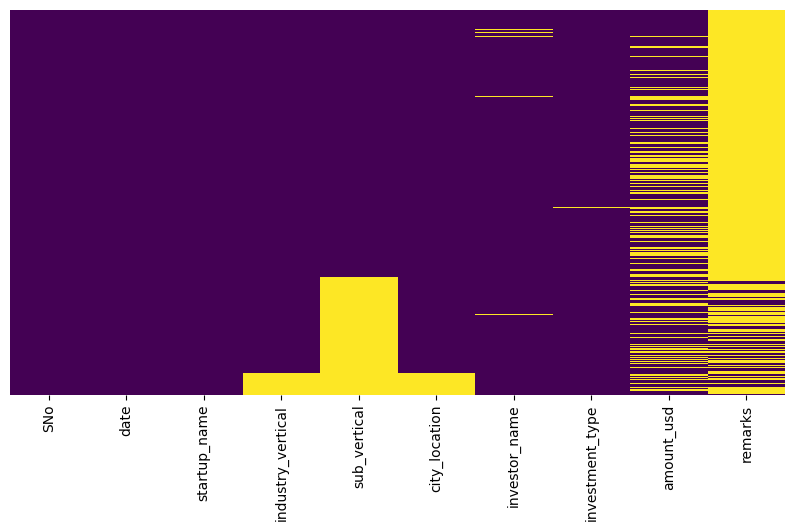

In [15]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(),cmap='viridis',yticklabels=False,cbar=False)
plt.show()

* Here yellow means missing data i.e. Nan values
* x axis represents columns of dataset

In [16]:
df.drop('remarks',axis=1,inplace=True)

In [17]:
df.columns

Index(['SNo', 'date', 'startup_name', 'industry_vertical', 'sub_vertical',
       'city_location', 'investor_name', 'investment_type', 'amount_usd'],
      dtype='object')

## Removing the inconsistency

* cleaning the date column

In [18]:
def clean_string(x):
    return str(x).replace("\\xc2\\xa0","").replace("\\\\xc2\\\\xa0","")

for col in ['startup_name', 'industry_vertical','sub_vertical','city_location', 'investor_name', 'investment_type', 'amount_usd']:
    df[col] = df[col].apply(lambda x: clean_string(x))


In [19]:
df['date'][df['date']=='01/07/015'] = '01/07/2015'
df['date'][df['date']=='\\\\xc2\\\\xa010/7/2015'] = '10/07/2015'
df['date'][df['date']=='12/05.2015'] = '12/05/2015'
df['date'][df['date']=='13/04.2015'] = '13/04/2015'
df['date'][df['date']=='15/01.2015'] = '15/01/2015'
df['date'][df['date']=='22/01//2015'] = '22/01/2015'
df['date'][df['date']=='05/072018'] = '05/07/2018'


C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\279225688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][df['date']=='01/07/015'] = '01/07/2015'
C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\279225688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][df['date']=='\\\\xc2\\\\xa010/7/2015'] = '10/07/2015'
C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\279225688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

* No Duplicate value present

In [20]:
df.duplicated().sum()

0

* converting string **"Amount_usd"** into numeric

In [21]:

df["amount_usd"] = df["amount_usd"].apply(lambda x: float(str(x).replace(",","").replace("undisclosed","0").replace("unknown","0").replace("Undisclosed","0").replace("+","").replace("N/A","0")))

df["amount_usd"] = pd.to_numeric(df["amount_usd"])
df.head()

,SNo,date,startup_name,industry_vertical,sub_vertical,city_location,investor_name,investment_type,amount_usd
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,200000000.0
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,8048394.0
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,18358860.0
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,3000000.0
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,1800000.0


# Analysis

How much funds does startups generally get in India (maximum funding, minimum funding, average funding and number of fundings)

In [22]:
max_funding = df["amount_usd"].dropna().sort_values().max()
print("Maximum funding to a Startup is :",max_funding)

Maximum funding to a Startup is : 3900000000.0


In [23]:
df[df.amount_usd == 3900000000.0]

,SNo,date,startup_name,industry_vertical,sub_vertical,city_location,investor_name,investment_type,amount_usd
60,61,27/08/2019,Rapido Bike Taxi,Transportation,Bike Taxi,Bengaluru,Westbridge Capital,Series B,3.900000e+09


As we can see **Rapido Bike Taxi** got maximum funding of 3900000000 USD.

In [24]:
exclude_zero = df[df['amount_usd'] != 0 ]
min_funding = exclude_zero["amount_usd"].dropna().sort_values().min()
print("Minimum funding to a startup is : ", min_funding)

Minimum funding to a startup is :  16000.0


In [25]:
df[df.amount_usd == 16000.0] 

,SNo,date,startup_name,industry_vertical,sub_vertical,city_location,investor_name,investment_type,amount_usd
3017,3018,19/01/2015,Hostel Dunia,nan,nan,nan,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
3018,3019,19/01/2015,Play your sport,nan,nan,nan,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
3019,3020,19/01/2015,Yo Grad,nan,nan,nan,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
3020,3021,19/01/2015,Enabli,nan,nan,nan,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0
3021,3022,19/01/2015,CBS,nan,nan,nan,Hyderabad Angels (at Startup Heroes event),Seed Funding,16000.0


In [26]:
min_funded_startup = df[df.amount_usd == 16000.0]['startup_name']

print("Minimum funded startups are:")
list(map(lambda x: print(x), min_funded_startup))

Minimum funded startups are:
Hostel Dunia
Play your sport
Yo Grad
Enabli
CBS


[None, None, None, None, None]

#### Average indian startup funding

In [27]:
avg_funding = round(df["amount_usd"].dropna().sort_values().mean())
print("On average indian startup got funding of :",avg_funding)

On average indian startup got funding of : 18303222


Total startups funded :  2457


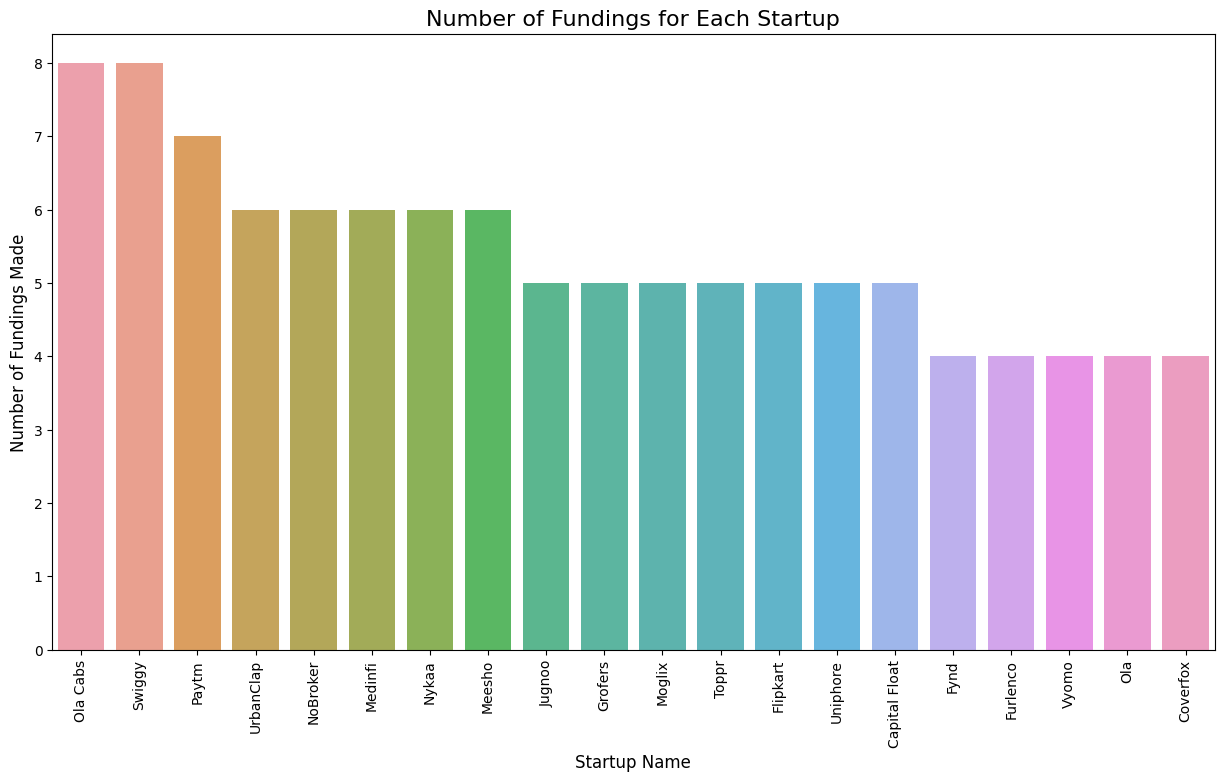

In [28]:
print("Total startups funded : ", len(df["startup_name"].unique()))
# Count the number of fundings for each startup name
startupname = df['startup_name'].value_counts().head(20)

# Plot the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=startupname.index, y=startupname.values,alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Startup Name', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Number of Fundings for Each Startup', fontsize=16)
plt.show()

* As we can see that **ola cabs and Swiggy** got maximum number of fundings (Total funding = 8) and total there are **2457** Indian startups funded from 2015 to 2020.

**Industires favored by investor for funding**
or
Companies got more easily funding

Consumer Internet    941
Technology           478
eCommerce            186
nan                  171
Healthcare            70
Finance               62
ECommerce             61
Logistics             32
E-Commerce            29
Education             24
Name: industry_vertical, dtype: int64


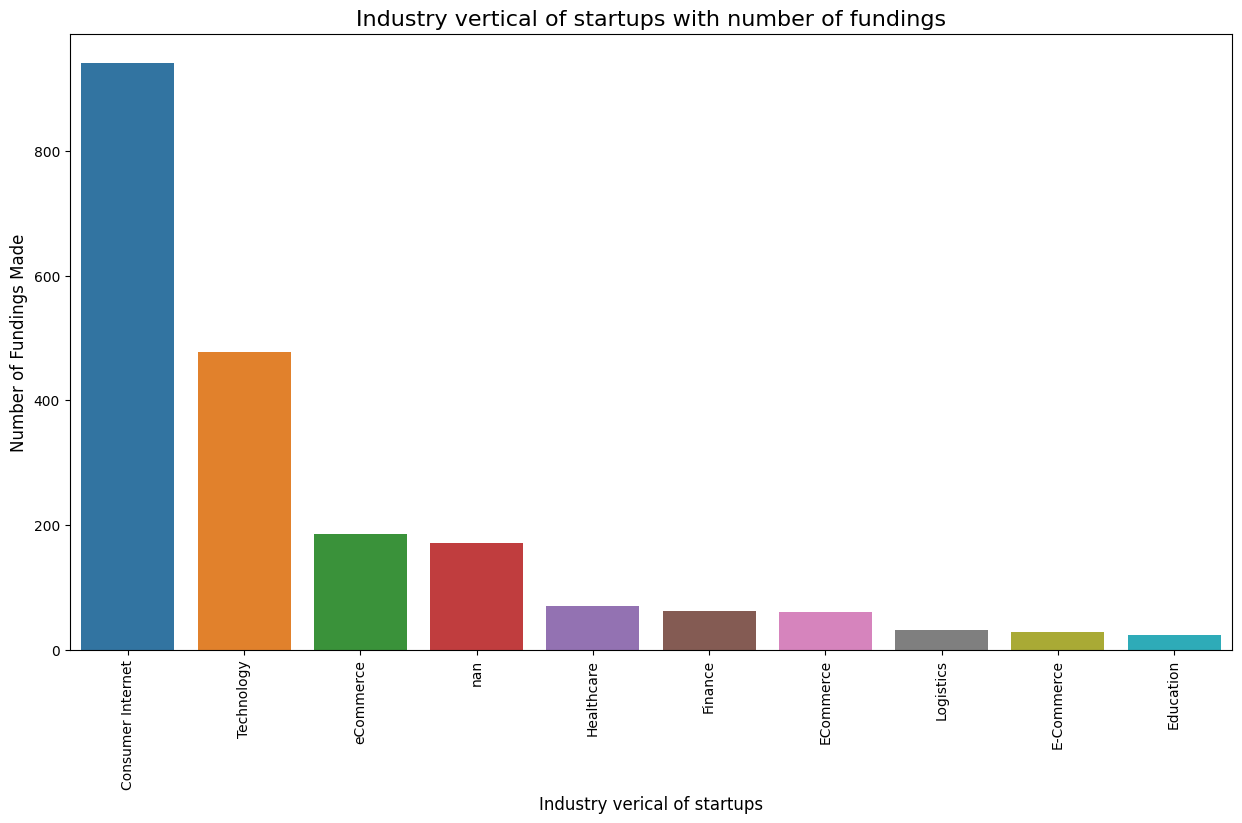

In [29]:
industry = df['industry_vertical'].value_counts().head(10)
print(industry)
plt.figure(figsize=(15,8))
sns.barplot(x=industry.index, y= industry.values)
plt.xticks(rotation='vertical')
plt.xlabel('Industry verical of startups', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Industry vertical of startups with number of fundings', fontsize=16)
plt.show()

* As we can see **Consumer Internet** got maximum number of funding (Total funding = 941) followed by technology and eCommerce.

Online Lending Platform          11
Online Pharmacy                  10
Food Delivery Platform            8
Online Education Platform         5
Education                         5
Online lending platform           5
Online Learning Platform          5
Online Lending                    5
Non-Banking Financial Company     4
Online Food Delivery              4
Name: sub_vertical, dtype: int64


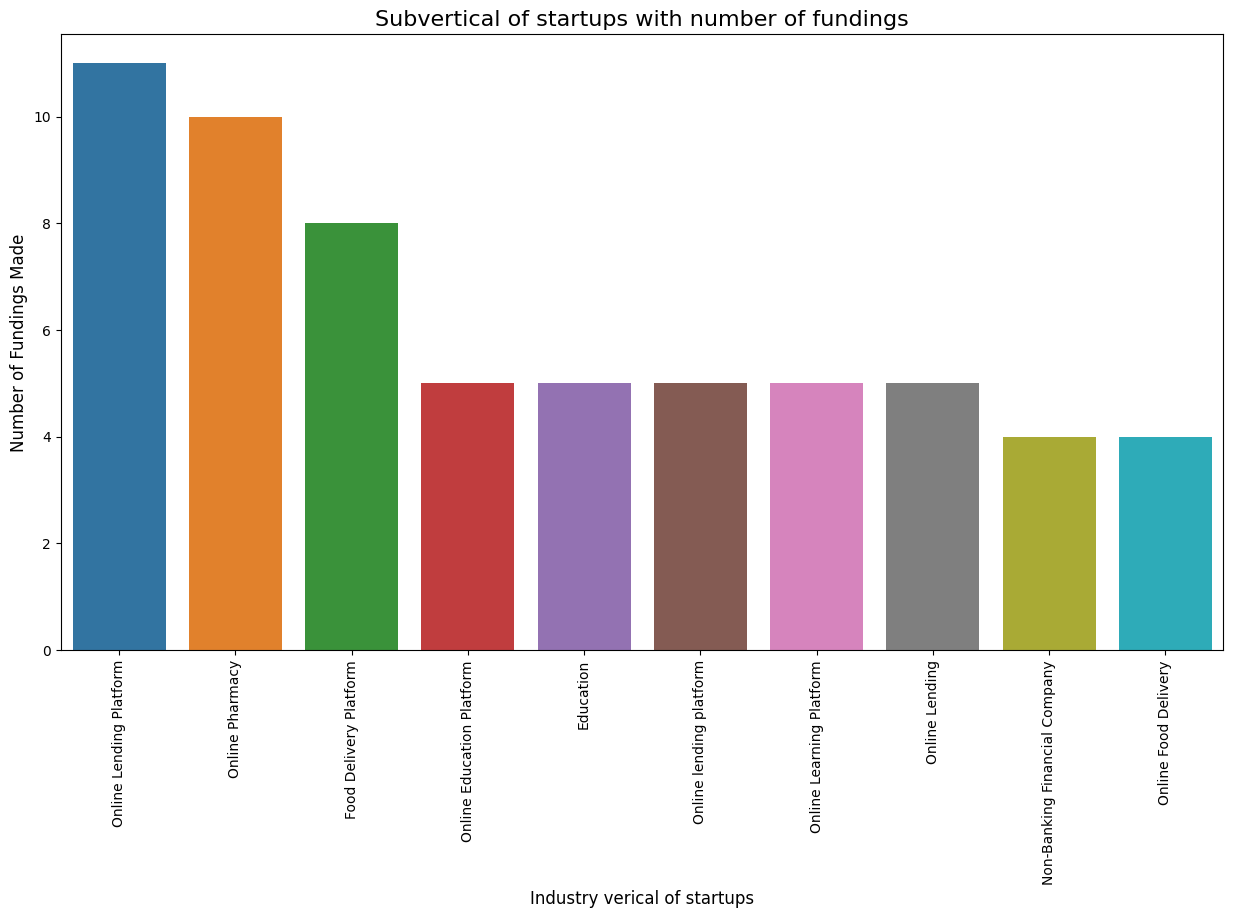

In [30]:
industry_filtered = df[df['sub_vertical'] != 'nan']
industry = industry_filtered['sub_vertical'].value_counts().head(10)
print(industry)
plt.figure(figsize=(15,8))
sns.barplot(x=industry.index, y= industry.values)
plt.xticks(rotation='vertical')
plt.xlabel('Industry verical of startups', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Subvertical of startups with number of fundings', fontsize=16)
plt.show()

In Subcategories **Online Landing Platform** got maximum number of fundings.

In [31]:
df.groupby(['city_location']).count()

,SNo,date,startup_name,industry_vertical,sub_vertical,investor_name,investment_type,amount_usd
city_location,,,,,,,,
Agra,2,2,2,2,2,2,2,0
Ahemadabad,2,2,2,2,2,2,2,2
Ahemdabad,1,1,1,1,1,1,1,0
Ahmedabad,38,38,38,38,38,38,38,27
Amritsar,1,1,1,1,1,1,1,1
Andheri,1,1,1,1,1,1,1,1
Bangalore,701,701,701,701,701,701,701,458
Bangalore / Palo Alto,1,1,1,1,1,1,1,1
Bangalore / SFO,2,2,2,2,2,2,2,2


## Do cities play a major role in funding ?

Bangalore    701
Mumbai       568
New Delhi    424
Gurgaon      291
Bengaluru    141
Pune         105
Hyderabad     99
Chennai       97
Noida         93
Gurugram      50
Name: city_location, dtype: int64


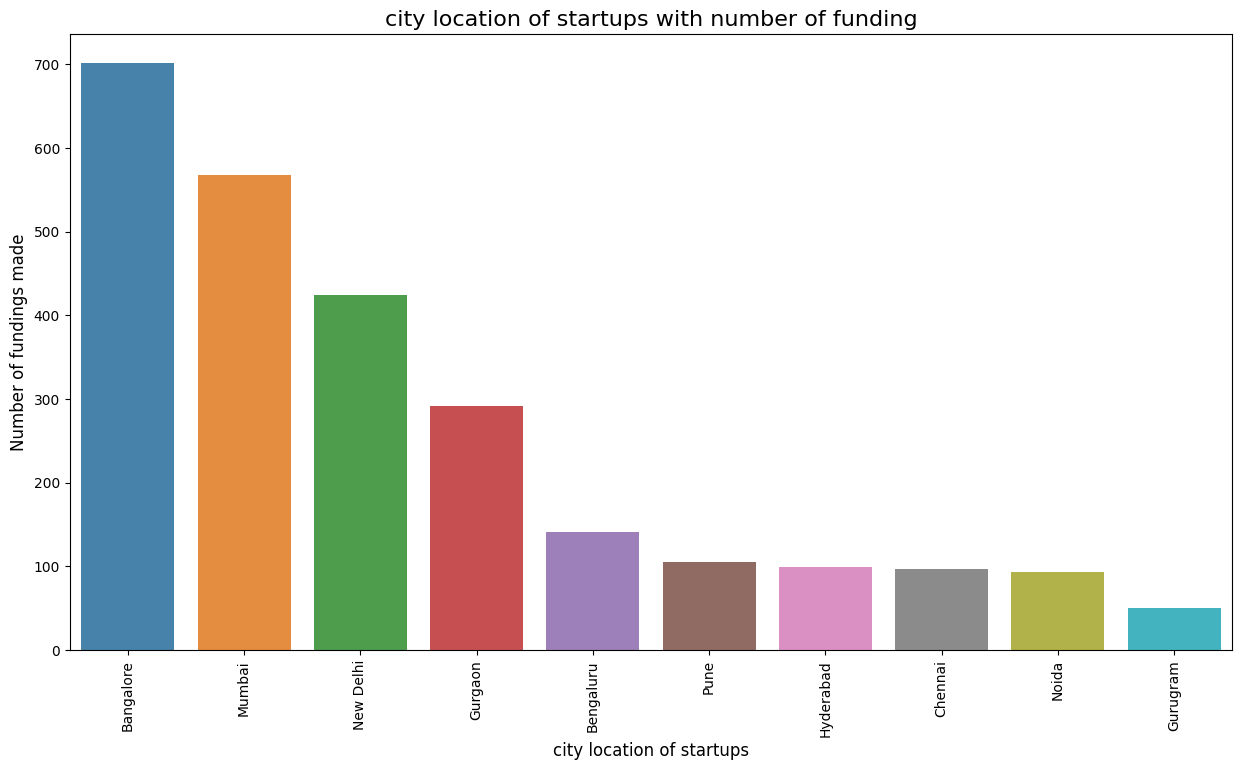

In [32]:
city_filtered = df[df['city_location'] != "nan"]
city = city_filtered['city_location'].value_counts().head(10)
print(city)
plt.figure(figsize=(15,8))
sns.barplot(x=city.index, y=city.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('city location of startups', fontsize=12)
plt.ylabel('Number of fundings made', fontsize=12)
plt.title("city location of startups with number of funding", fontsize=16)
plt.show()

Distribution of startups across Top Different cities

Text(0.5, 1.0, 'Distribution of startups across Top 20 Cities')

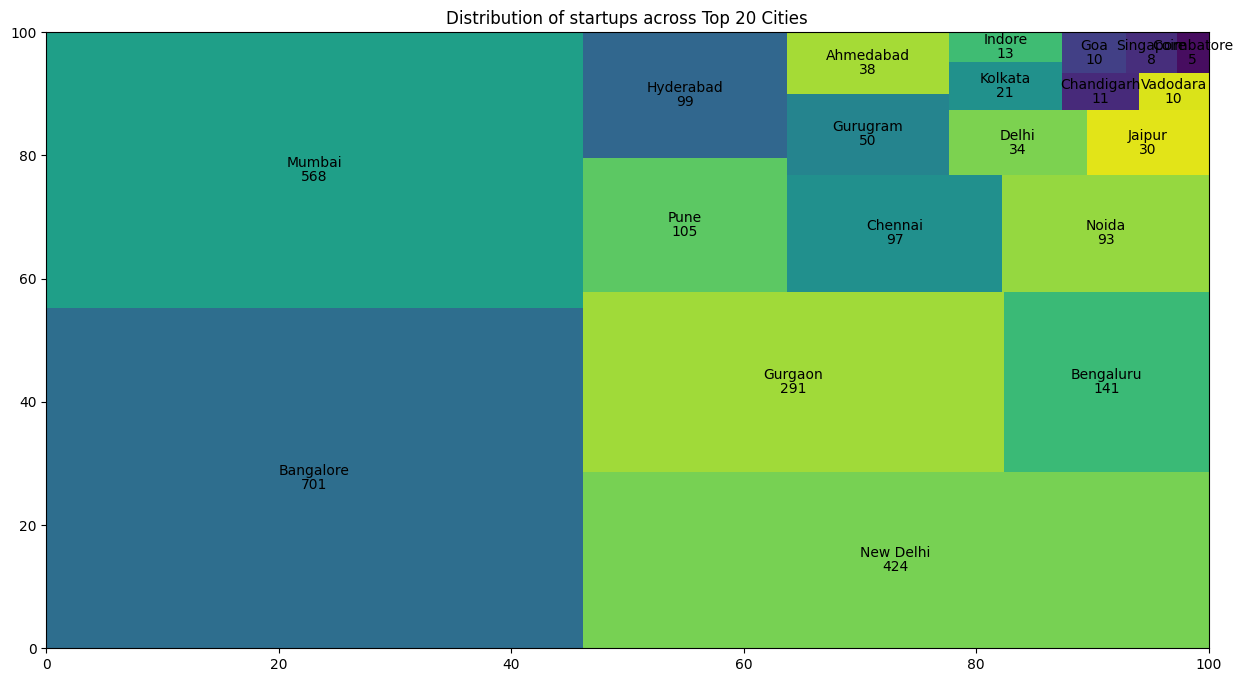

In [34]:
count = city_filtered['city_location'].value_counts().head(20)
plt.figure(figsize=(15,8))
squarify.plot(sizes=count.values,label=count.index,value=count.values)
plt.title("Distribution of startups across Top 20 Cities")

* We can see **Banglore** attracts more number of investors folowed by Mumbai and New Delhi

## Important investors in Indian Ecosystem

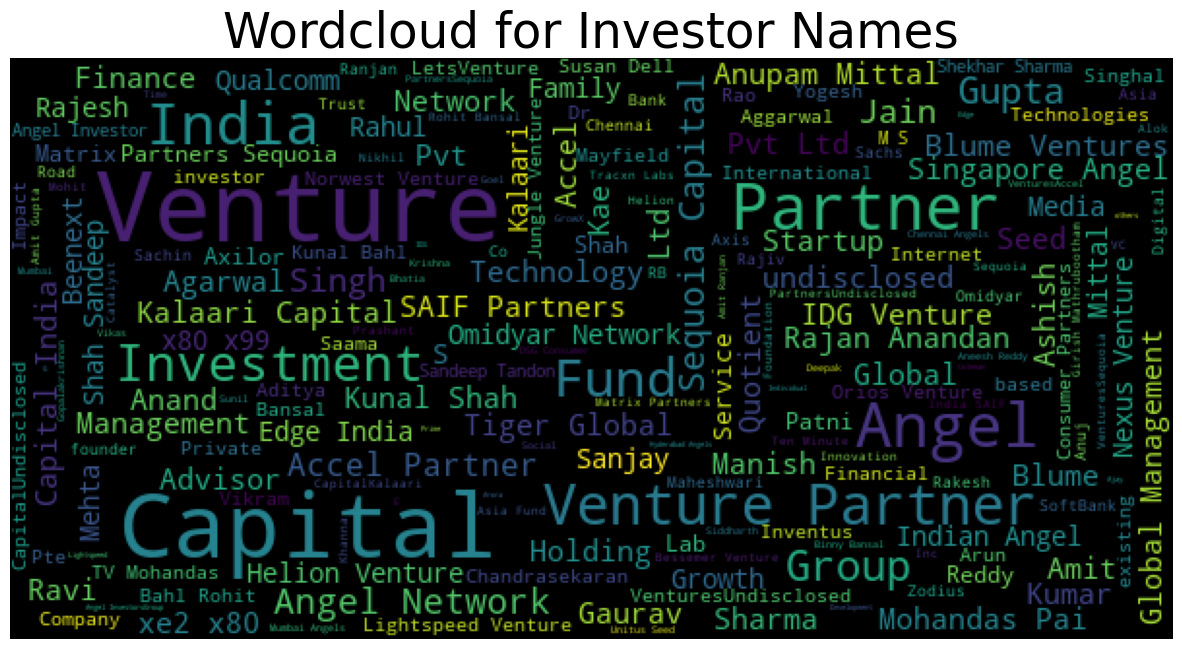

In [35]:
from wordcloud import WordCloud

names = df['investor_name'][~pd.isnull(df['investor_name'])]

wordcloud = WordCloud(max_font_size=50,width=600,height=300).generate(''.join(names))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Investor Names", fontsize=35)
plt.axis("off")
plt.show()


## Top 10 Investors

In [36]:
df['investor_name'][df['investor_name'] == 'Undisclosed investors'] = 'Undisclosed Investors'

df['investor_name'][df['investor_name'] == 'Undisclosed Investor'] = 'Undisclosed Investors'

df['investor_name'][df['investor_name'] == 'Undisclosed'] = 'Undisclosed Investors'

df['investor_name'][df['investor_name'] == 'undisclosed investors'] = 'Undisclosed Investors'

df['investor_name'][df['investor_name'] == 'nan'] = 'Undisclosed Investors'


C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\2096212315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['investor_name'][df['investor_name'] == 'Undisclosed investors'] = 'Undisclosed Investors'
C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\2096212315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['investor_name'][df['investor_name'] == 'Undisclosed Investor'] = 'Undisclosed Investors'
C:\Users\neerb\AppData\Local\Temp\ipykernel_20944\2096212315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [37]:
investors = df['investor_name'].value_counts().head(10)
print(investors)

Undisclosed Investors       127
Ratan Tata                   25
Indian Angel Network         24
Kalaari Capital              16
Sequoia Capital              15
Group of Angel Investors     15
Accel Partners               12
Venture Catalysts            11
Brand Capital                11
RoundGlass Partners          10
Name: investor_name, dtype: int64


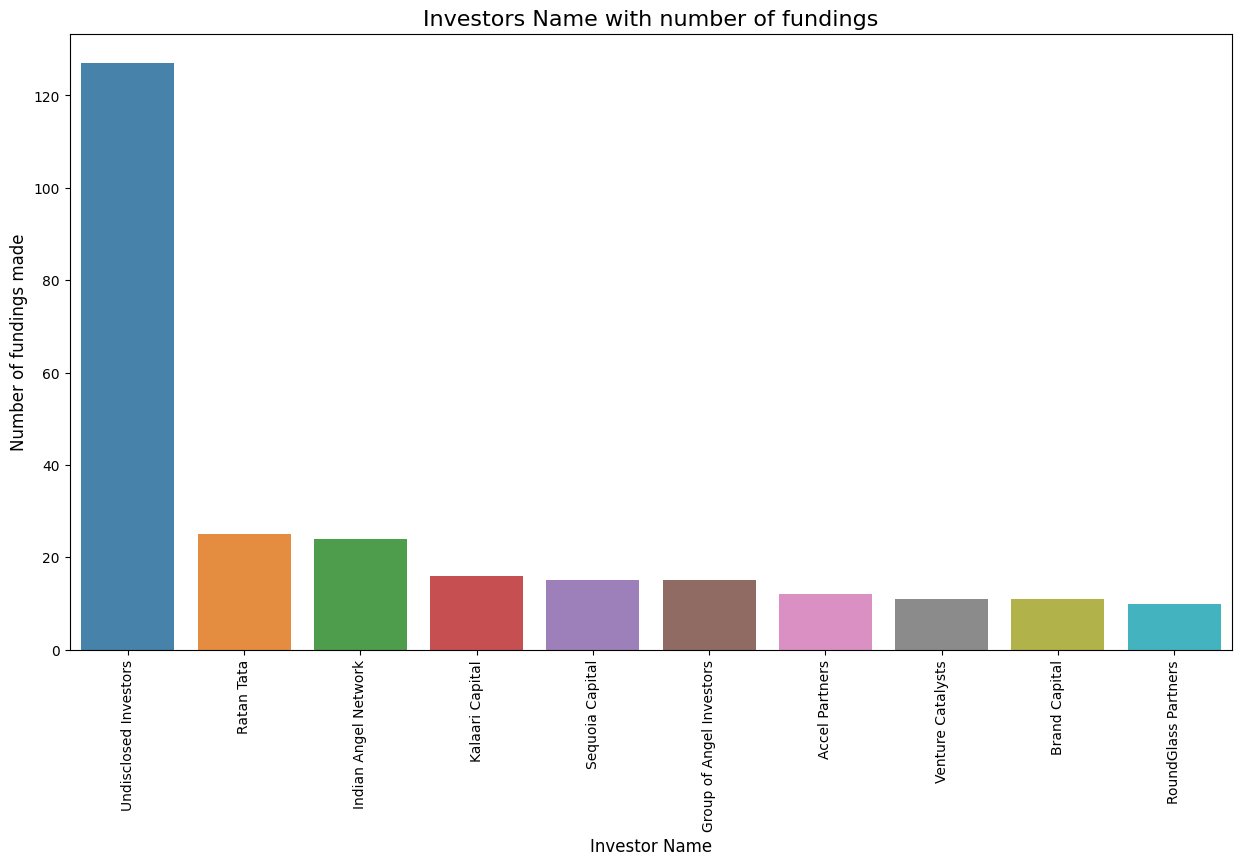

In [38]:
plt.figure(figsize=(15,8))
sns.barplot(x=investors.index, y=investors.values,alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Investor Name',fontsize=12)
plt.ylabel('Number of fundings made',fontsize=12)
plt.title("Investors Name with number of fundings", fontsize=16)
plt.show()


* **Ratan Tata and Indian Angel Newtork** funded in maximum number of startups 
* there is a huge number of funding done which is undisclosed to public

### Number of funding over the years

In [39]:
df["year"] = pd.to_datetime(df['date'],format='%d/%m/%Y').dt.year
df["yearmonth"] = (pd.to_datetime(df['date'],format='%d/%m/%Y').dt.year*100)+(pd.to_datetime(df['date'],format='%d/%m/%Y').dt.month)

In [40]:
cnt_srs = df['year'].value_counts()
cnt_srs = cnt_srs.sort_index()
cnt_srs

2015    936
2016    993
2017    687
2018    310
2019    111
2020      7
Name: year, dtype: int64

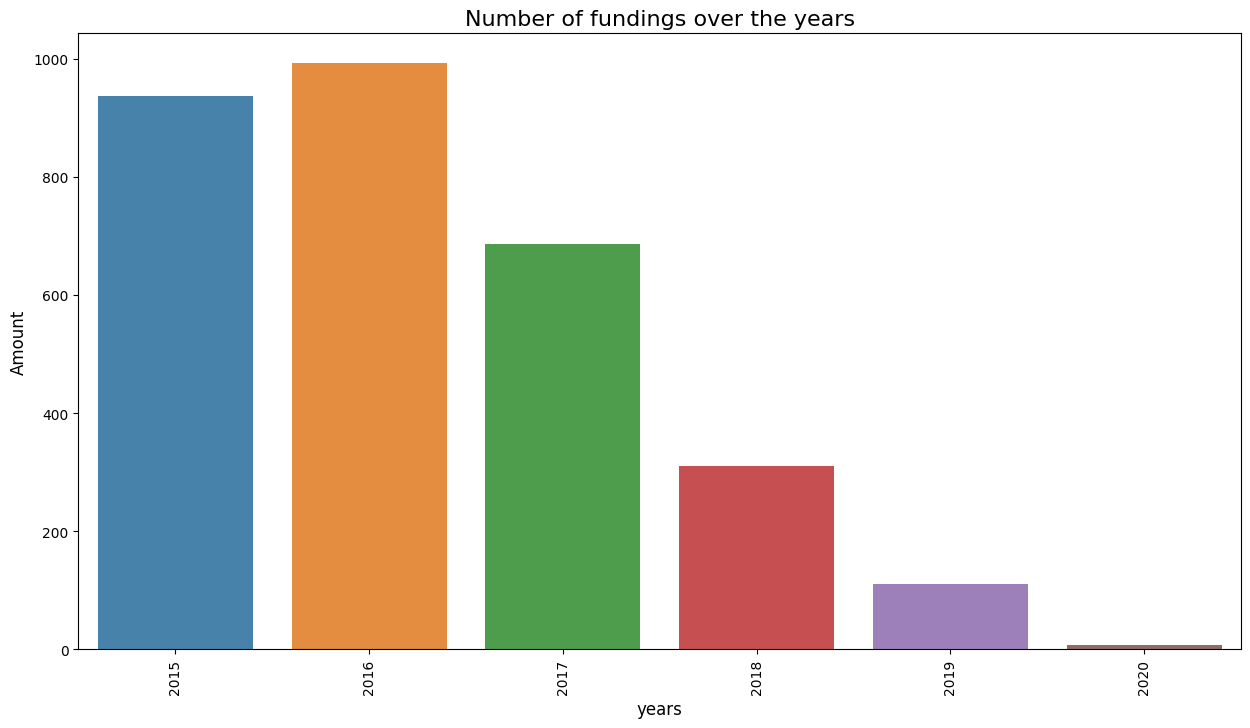

In [41]:
plt.figure(figsize=(15,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values,alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('years',fontsize=12)
plt.ylabel('Amount',fontsize=12)
plt.title("Number of fundings over the years", fontsize=16)
plt.show()

* Year 2015 and 2016 have more number of fundings comared to the recent years
* Tere is a clear decling trend in the number of funding deals from 2016

### Month by Month Number of fundings

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SNo                3044 non-null   int64  
 1   date               3044 non-null   object 
 2   startup_name       3044 non-null   object 
 3   industry_vertical  3044 non-null   object 
 4   sub_vertical       3044 non-null   object 
 5   city_location      3044 non-null   object 
 6   investor_name      3044 non-null   object 
 7   investment_type    3044 non-null   object 
 8   amount_usd         2084 non-null   float64
 9   year               3044 non-null   int64  
 10  yearmonth          3044 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 261.7+ KB


In [43]:
df.sample(5)

,SNo,date,startup_name,industry_vertical,sub_vertical,city_location,investor_name,investment_type,amount_usd,year,yearmonth
2596,2597,08/07/2015,Ampere,Electric Scooter manufacturer,nan,Coimbatore,Ratan Tata,Seed Funding,NaN,2015,201507
410,411,22/01/2018,Skillate,Technology,Artificial Intellegence,Bengaluru,"Incubate Fund India, Anuj Agrawal",Private Equity,NaN,2018,201801
1891,1892,23/03/2016,HashLearn,Consumer Internet,Mobile based private tutoring services,nan,"Bhavish Aggarwal, Binny Bansal, Rajan Anandan,...",Seed Funding,NaN,2016,201603
2786,2787,19/05/2015,Akosha,Business Messaging App,nan,New Delhi,Sequoia Capital,Private Equity,16000000.0,2015,201505
2281,2282,27/11/2015,Talentrack,Talent Exchange & Talent Services Marketplace,nan,New Delhi,Unigrowth Inc,Seed Funding,NaN,2015,201511
